In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Subsection 1.2.
import cftime
import datetime as dt
import xarray
from netCDF4 import Dataset, date2index, num2date, date2num

# Subsections 2.1. and 2.2.
from sklearn import datasets
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, NuSVC, LinearSVC, SVR, LinearSVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

import diagrams as diag

In [2]:
__author__ = 'Aleksandar Anžel'
__copyright__ = ''
__credits__ = ['Aleksandar Anžel', 'Georges Hattab']
__license__ = 'GNU General Public License v3.0'
__version__ = '1.0'
__maintainer__ = 'Aleksandar Anžel'
__email__ = 'aleksandar.anzel@uni-marburg.de'
__status__ = 'Dev'

# General description

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [16]:
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

path_root_data = os.path.join('..', 'Data')
path_root_data_results = os.path.join(path_root_data, 'Resuts')

if not os.path.exists(path_root_data_results):
    os.mkdir(path_root_data_results)

INT_RANDOM_SEED = 42
np.random.seed(INT_RANDOM_SEED)

In [4]:
def df_generate_new_timepoint(df_input):
    """
    df_generate_new_timepoint adds noise to each column of the input dataframe,
    thus creating a slightly modified version of that dataframe. This version
    can be considered a snapshot of a phenomenon in a different time point.
    
    Args:
        pd.DataFrame(): An input dataframe that contains models in columns.
    
    Returns:
        pd.DataFrame(): An output dataframe which comes from the procedure
        described above.
    """
    
    df_result = pd.DataFrame()
    int_len = df_input.shape[0]
    for string_one_column in df_input.columns:
        df_result[string_one_column] = df_input[
            string_one_column].to_numpy() + np.random.normal(0, 1, int_len)
    
    return df_result

# 1. Paper reconstruction
## 1.1. Anscombe's Quartet
### 1.1.1. Original dataset with the visualization from the paper

In [5]:
path_anscombes_quartet = os.path.join(
    path_root_data, 'Dataset_0', 'Anscombes_Quartet.csv')

df_anscombes_quartet = pd.read_csv(path_anscombes_quartet)
df_anscombes_quartet

x1     y1    x2    y2    x3     y3    x4     y4
0   10.0   8.04  10.0  9.14  10.0   7.46   8.0   6.58
1    8.0   6.95   8.0  8.14   8.0   6.77   8.0   5.76
2   13.0   7.58  13.0  8.74  13.0  12.74   8.0   7.71
3    9.0   8.81   9.0  8.77   9.0   7.11   8.0   8.84
4   11.0   8.33  11.0  9.26  11.0   7.81   8.0   8.47
5   14.0   9.96  14.0  8.10  14.0   8.84   8.0   7.04
6    6.0   7.24   6.0  6.13   6.0   6.08   8.0   5.25
7    4.0   4.26   4.0  3.10   4.0   5.39  19.0  12.50
8   12.0  10.84  12.0  9.13  12.0   8.15   8.0   5.56
9    7.0   4.82   7.0  7.26   7.0   6.42   8.0   7.91
10   5.0   5.68   5.0  4.74   5.0   5.73   8.0   6.89

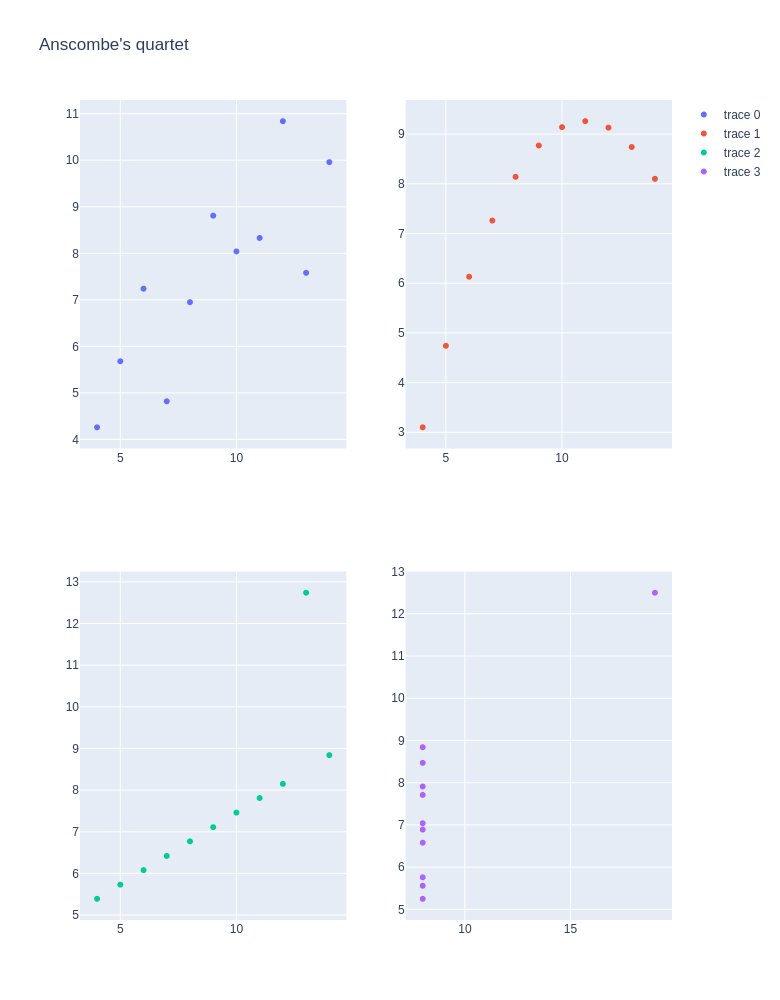

In [6]:
def chart_scatter_anscombes_quartet(df_input):
    
    chart_result = make_subplots(rows=2, cols=2)

    chart_result.add_trace(
        go.Scatter(x=df_input['x1'], y=df_input['y1'], mode="markers"),
        row=1, col=1
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x2'], y=df_input['y2'], mode="markers"),
        row=1, col=2
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x3'], y=df_input['y3'], mode="markers"),
        row=2, col=1
    )
    
    chart_result.add_trace(
        go.Scatter(x=df_input['x4'], y=df_input['y4'], mode="markers"),
        row=2, col=2
    )
    
    chart_result.update_layout(height=1000, title_text="Anscombe's quartet")
    
    return chart_result


chart_anscombes = chart_scatter_anscombes_quartet(df_anscombes_quartet)
chart_anscombes.show()
    

In [7]:
df_anscombes_quartet_modified = df_anscombes_quartet.drop(
    ['x1', 'x2', 'x3', 'x4'], axis=1)
df_anscombes_quartet_modified

y1    y2     y3     y4
0    8.04  9.14   7.46   6.58
1    6.95  8.14   6.77   5.76
2    7.58  8.74  12.74   7.71
3    8.81  8.77   7.11   8.84
4    8.33  9.26   7.81   8.47
5    9.96  8.10   8.84   7.04
6    7.24  6.13   6.08   5.25
7    4.26  3.10   5.39  12.50
8   10.84  9.13   8.15   5.56
9    4.82  7.26   6.42   7.91
10   5.68  4.74   5.73   6.89

In [8]:
string_mid_type = 'scaled'
string_corr_method='pearson'

bool_discrete_anscombes = False

dict_mi_parameters_features_discrete_target_discrete = dict(
    string_entropy_method='auto',
    int_mi_n_neighbors=3,
    bool_discrete_reference_model=True,
    discrete_models=True,
    int_random_state=INT_RANDOM_SEED)

dict_mi_parameters_features_discrete_target_continous = dict(
    string_entropy_method='auto',
    int_mi_n_neighbors=3,
    bool_discrete_reference_model=False,
    discrete_models=True,
    int_random_state=INT_RANDOM_SEED)

dict_mi_parameters_features_continous_target_discrete = dict(
    string_entropy_method='auto',
    int_mi_n_neighbors=3,
    bool_discrete_reference_model=True,
    discrete_models=False,
    int_random_state=INT_RANDOM_SEED)

dict_mi_parameters_features_continous_target_continous = dict(
    string_entropy_method='auto',
    int_mi_n_neighbors=3,
    bool_discrete_reference_model=False,
    discrete_models=False,
    int_random_state=INT_RANDOM_SEED)

In [9]:
string_ref_model = 'y4'
df_taylor_res = diag.df_calculate_all_properties(df_anscombes_quartet_modified, string_ref_model, string_corr_method=string_corr_method, dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)
df_taylor_res

Model  Standard Deviation  Correlation       Angle       RMS  \
0    y1            1.937024    -0.489116  119.282510  3.342016   
1    y2            1.937109    -0.478095  118.561047  3.329698   
2    y3            1.935933    -0.155472   98.944159  2.943077   
3    y4            1.936081     1.000000    0.000000  0.000000   

   Normalized_RMS  Normalized_STD   Entropy  Mutual Information  Fixed_MI  \
0        1.726176        1.000487  2.852820            0.000000  0.000000   
1        1.719814        1.000531  2.312211            0.000000  0.000000   
2        1.520121        0.999924  2.618974            0.000000  0.000000   
3        0.000000        1.000000  2.711054            1.095635  2.711054   

   Scaled_entropy  Normalized MI  Angle_NMI  Joint_entropies  Scaled MI  \
0        1.052292            0.0       90.0         5.563874        0.0   
1        0.852883            0.0       90.0         5.023265        0.0   
2        0.966036            0.0       90.0         5.330028        0.0   
3        1.000000            1.0        0.0         2.711054        1.0   

   Angle_SMI  Root Entropy  
0      180.0      1.689029  
1      180.0      1.520596  
2      180.0      1.618325  
3        0.0      1.646528

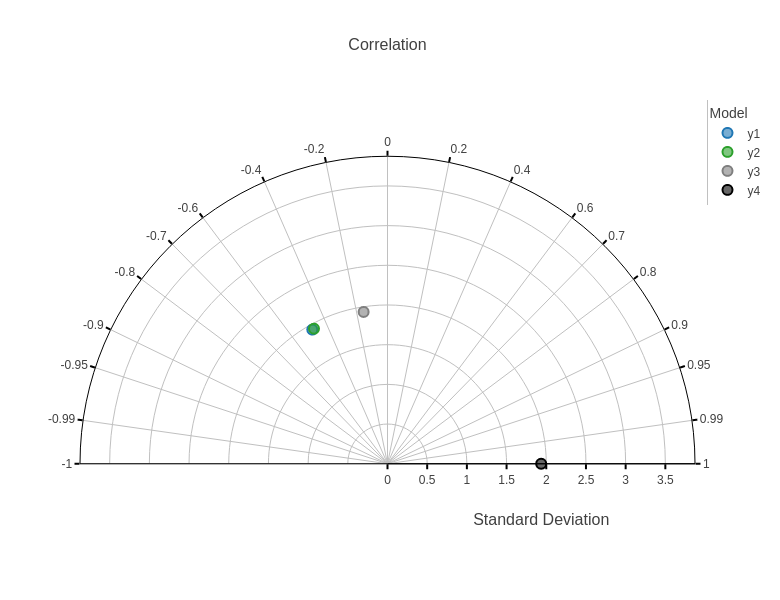

In [10]:
chart_taylor_res = diag.chart_create_taylor_diagram(df_anscombes_quartet_modified, string_ref_model, string_corr_method)
chart_taylor_res.show()

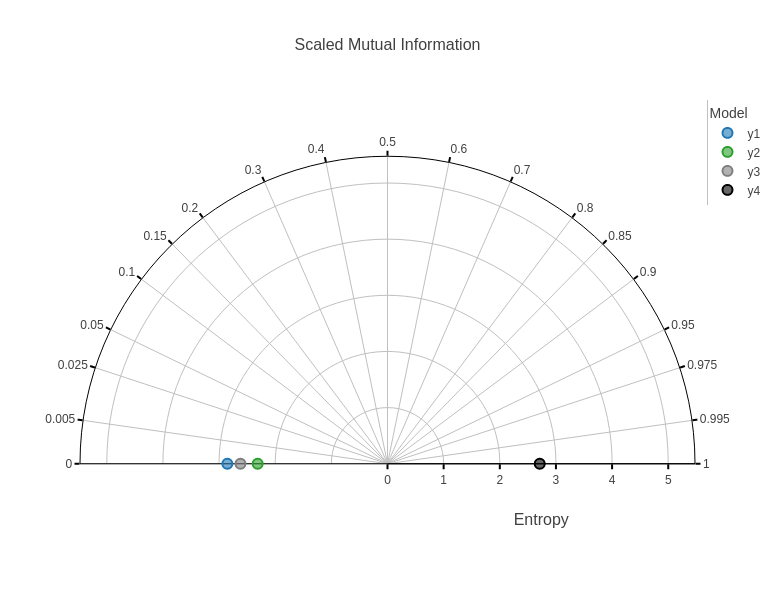

In [11]:
chart_taylor_res = diag.chart_create_mi_diagram(df_anscombes_quartet_modified, string_ref_model, string_mid_type, dict_mi_parameters_features_continous_target_continous)
chart_taylor_res.show()

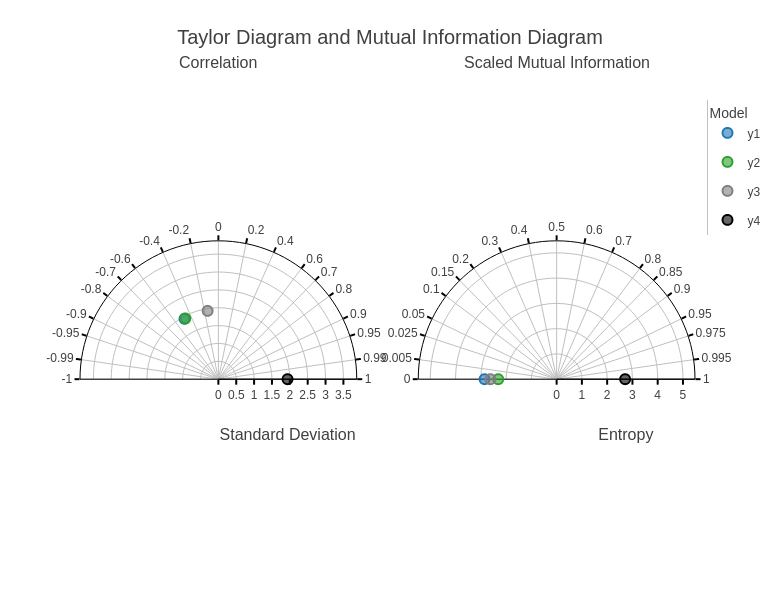

In [12]:
diag.chart_create_all_diagrams(df_anscombes_quartet_modified, string_ref_model, string_corr_method, string_mid_type, dict_mi_parameters_features_continous_target_continous)

### 1.1.2. Use case with two time points

Here we add noise to the original Anscombe's Quartet dataset. The resulting dataset has slightly shifted data.


In [13]:
df_anscombes_quartet_modified_with_noise = df_generate_new_timepoint(df_anscombes_quartet_modified)
df_anscombes_quartet_modified_with_noise

y1        y2         y3         y4
0    8.536714  8.674270   7.527528   5.522289
1    6.811736  8.381962   5.345252   6.582545
2    8.227689  6.826720  12.195617   6.489156
3   10.333030  7.045082   7.220923   9.048864
4    8.095847  8.697712   6.659006   6.510330
5    9.725863  7.087169   9.215698   5.711814
6    8.819213  6.444247   5.479361   5.446861
7    5.027435  2.191976   5.098306  13.238467
8   10.370526  7.717696   7.548293   5.731368
9    5.362560  8.725649   8.272278   7.794352
10   5.216582  4.514224   5.716503   6.588896

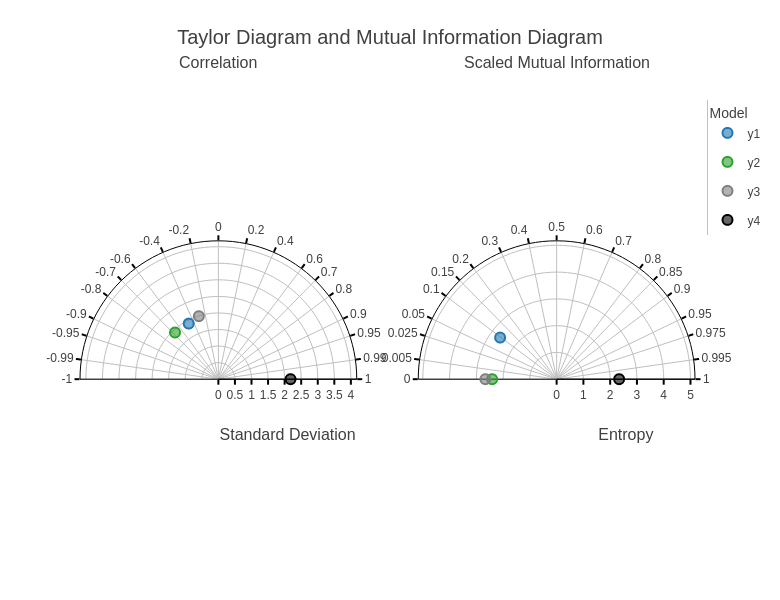

In [14]:
diag.chart_create_all_diagrams(df_anscombes_quartet_modified_with_noise, string_ref_model, string_corr_method, string_mid_type, dict_mi_parameters_features_continous_target_continous)

---
We can see that different time points have different color saturation. The second time point is darker than the first one. One could also differentiate time points using a tooltip that appears on mouse hover over the circles.

---

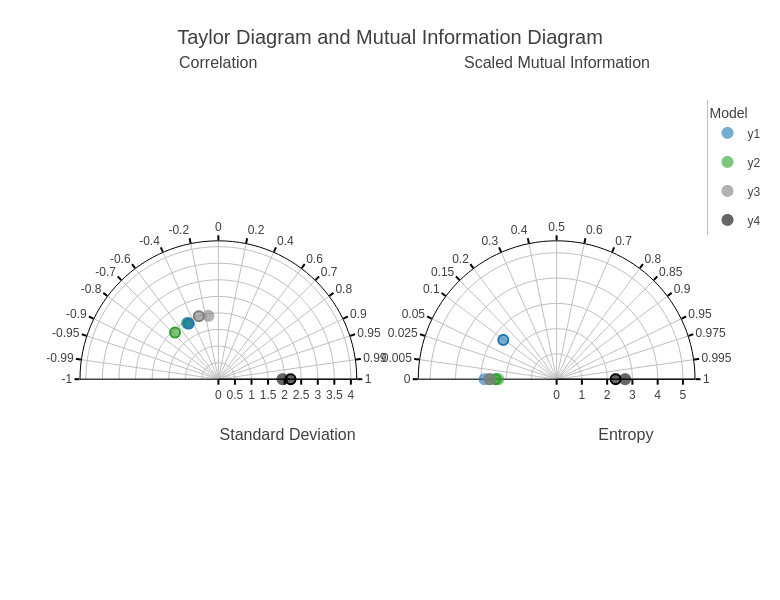

In [15]:
diag.chart_create_all_diagrams([df_anscombes_quartet_modified, df_anscombes_quartet_modified_with_noise], string_ref_model, string_corr_method, string_mid_type, dict_mi_parameters_features_continous_target_continous)

---
Here we create a new dataset with the same models as the original dataset but only one scalar value for each model. We will call here this scalar value 'bias'. We can see that 'bias' is visualized using a concentric circle.

---

In [16]:
df_anscombes_quartet_bias = pd.DataFrame().from_dict(
    {'row_1': np.random.random_sample(df_anscombes_quartet_modified.shape[1])},
    orient='index', columns=df_anscombes_quartet_modified.columns)
df_anscombes_quartet_bias

y1        y2        y3        y4
row_1  0.388677  0.271349  0.828738  0.356753

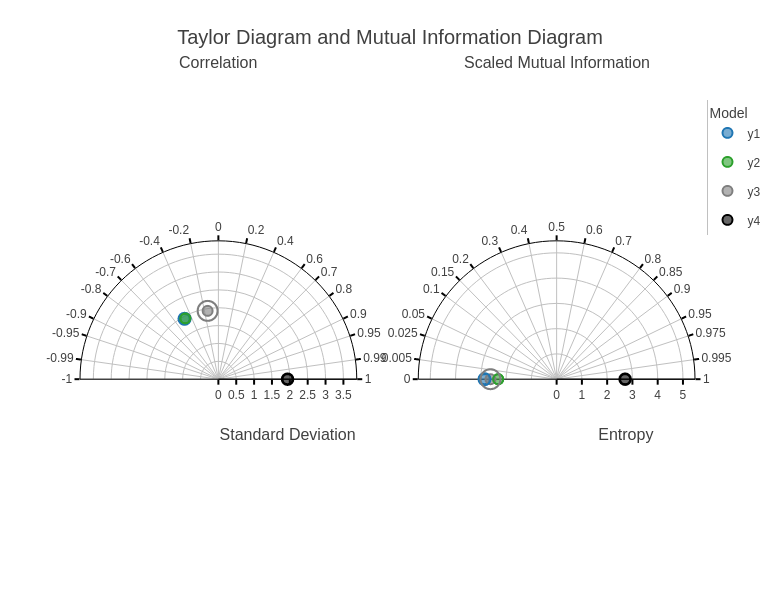

In [17]:
diag.chart_create_all_diagrams([df_anscombes_quartet_modified, df_anscombes_quartet_bias], string_ref_model, string_corr_method, string_mid_type, dict_mi_parameters_features_continous_target_continous)

## 1.2. CMIP3 Dataset - Historical Temperature Experiment

---

**IMPORTANT**
* How to generate wget script: https://esgf.github.io/esgf-user-support/faq.html#how-to-preserve-the-directory-structure
* Link to wget script used here: https://esgf-data.dkrz.de/esg-search/wget?download_structure=model&project=CMIP3&experiment=historical&ensemble=run1&variable=ts

---

In [18]:
def test_dataset_1():
    
    # IMPORTANT
    ###########################################################################
    # How to generate wget script: https://esgf.github.io/esgf-user-support/faq.html#how-to-preserve-the-directory-structure
    # Link to wget script used here: https://esgf-data.dkrz.de/esg-search/wget?download_structure=model&project=CMIP3&experiment=historical&ensemble=run1&variable=ts
    ###########################################################################
    path_dataset_1 = os.path.join(path_root_data, 'Dataset_1', 'Files')
    
    float_kelvin = 273.15
    
    list_datetimes = []
    list_temperatures = []
    list_models = []
    
    # Each name is encoded as a directory name
    list_model_names = [i for i in os.listdir(path_dataset_1)
                        if os.path.isdir(os.path.join(path_dataset_1, i))]
    
    for i, string_one_model in enumerate(list_model_names):
        path_one_model_dir = os.path.join(path_dataset_1, string_one_model)
        
        if string_one_model in ['ncar_ccsm3_0', 'mri_cgcm2_3_2a']:
            continue
        
        for j, string_one_model_file in enumerate(os.listdir(path_one_model_dir)):
        
            path_one_model_file = os.path.join(
                path_one_model_dir, string_one_model_file)
            
            ds_one_model_file = xarray.open_dataset(
                path_one_model_file, decode_times=True, use_cftime=True)
            
            try:
                # Time slicing for the 20th century
                ds_one_model_file_20th_century = ds_one_model_file.sel(
                    time=slice('1900-01-01','2000-01-01'))

                # Anual resampling
                ds_one_model_file_20th_century_mean = ds_one_model_file_20th_century.resample(time='AS').mean()

                ds_one_model_file_temperature = ds_one_model_file_20th_century_mean.variables['ts'].to_numpy()
                ds_one_model_file_time = ds_one_model_file_20th_century_mean.indexes['time'].to_datetimeindex()

                list_datetimes += ds_one_model_file_time.tolist()

                # Taking geographicall mean besides temporal
                np_tmp_temp = np.array(ds_one_model_file_temperature)
                list_geographically_mean_temperatures = np_tmp_temp.mean(axis=(1,2)).tolist()
                list_temperatures += list_geographically_mean_temperatures

                list_models += [string_one_model] * len(list_geographically_mean_temperatures)
            
            except:
                continue
    
    df_dataset_1 = pd.DataFrame(
        {'Datetime': list_datetimes, 'Temperature': list_temperatures,
         'Model': list_models})
    
    return df_dataset_1


df_dataset_1 = test_dataset_1()
df_dataset_1

/tmp/ipykernel_18762/2023645653.py:43: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_18762/2023645653.py:43: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_18762/2023645653.py:43: RuntimeWarning:

Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.

/tmp/ipykernel_18762/2023645653.py:43: RuntimeWarning:

Converting a CFTimeIndex with dates from a

Datetime  Temperature        Model
0    1900-01-01   277.047333  csiro_mk3_0
1    1901-01-01   277.297546  csiro_mk3_0
2    1902-01-01   277.272705  csiro_mk3_0
3    1903-01-01   277.158569  csiro_mk3_0
4    1904-01-01   277.016510  csiro_mk3_0
...         ...          ...          ...
2195 1995-01-01   279.009399   mpi_echam5
2196 1996-01-01   279.209564   mpi_echam5
2197 1997-01-01   279.184357   mpi_echam5
2198 1998-01-01   279.009308   mpi_echam5
2199 1999-01-01   278.867401   mpi_echam5

[2200 rows x 3 columns]

In [19]:
df_dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datetime     2200 non-null   datetime64[ns]
 1   Temperature  2200 non-null   float64       
 2   Model        2200 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 51.7+ KB


In [20]:
df_dataset_1['Model'].unique()

array(['csiro_mk3_0', 'ukmo_hadcm3', 'ipsl_cm4', 'miub_echo_g',
       'bccr_bcm2_0', 'cccma_cgcm3_1_t63', 'iap_fgoals1_0_g',
       'cccma_cgcm3_1', 'ingv_echam4', 'ncar_pcm1', 'gfdl_cm2_1',
       'cnrm_cm3', 'giss_aom', 'gfdl_cm2_0', 'ukmo_hadgem1', 'inmcm3_0',
       'giss_model_e_h', 'miroc3_2_hires', 'csiro_mk3_5',
       'giss_model_e_r', 'miroc3_2_medres', 'mpi_echam5'], dtype=object)

In [21]:
len(df_dataset_1['Model'].unique())

22

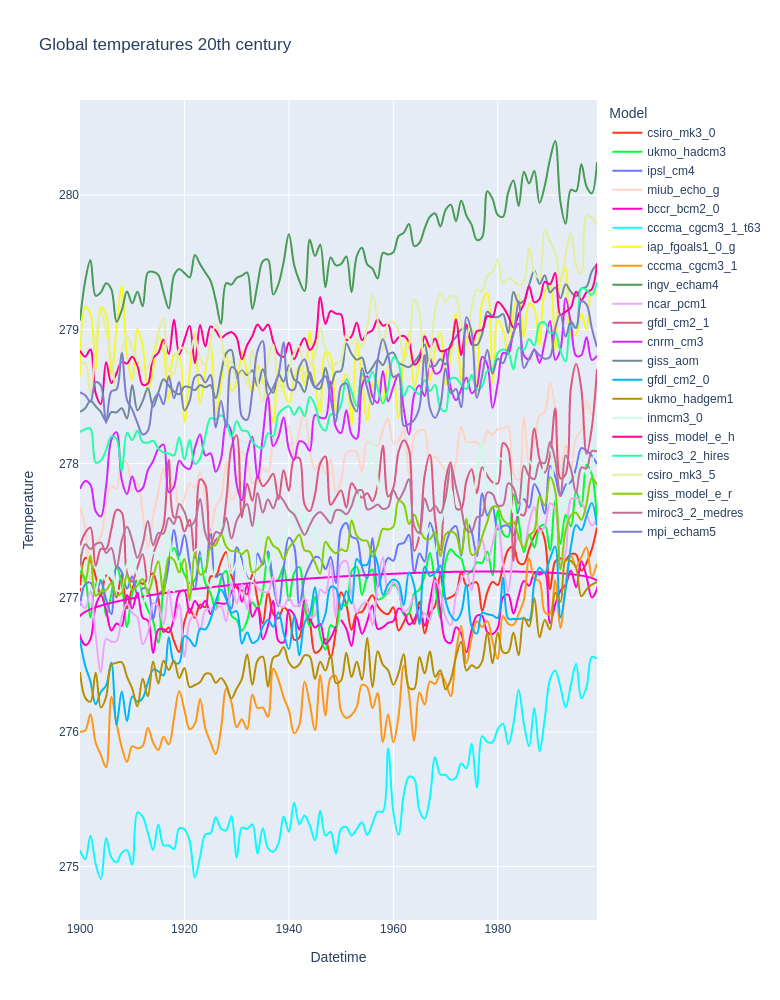

In [22]:
fig = px.line(df_dataset_1, x='Datetime', y='Temperature', color='Model',
              title='Global temperatures 20th century', render_mode='svg',
              line_shape='spline',
              color_discrete_sequence=px.colors.qualitative.Light24,)
fig.update_layout(height=1000)
fig.show()

In [23]:
df_dataset_1_pivoted = pd.pivot(df_dataset_1, index=['Datetime'], columns=['Model'], values=['Temperature']).reset_index(drop=True)
df_dataset_1_pivoted.columns = df_dataset_1_pivoted.columns.get_level_values(1)
df_dataset_1_pivoted

Model  bccr_bcm2_0  cccma_cgcm3_1  cccma_cgcm3_1_t63    cnrm_cm3  csiro_mk3_0  \
0       276.865601     276.002563         275.119843  277.812378   277.047333   
1       276.648376     276.011749         275.053864  277.870117   277.297546   
2       276.692078     276.133514         275.228760  277.842987   277.272705   
3       276.940002     275.921570         275.017639  277.646393   277.158569   
4       277.016418     275.829468         274.906097  277.607147   277.016510   
..             ...            ...                ...         ...          ...   
95      277.078735     277.233032         276.508240  278.803253   277.323029   
96      277.273438     277.303558         276.251526  278.808105   277.202087   
97      277.156433     277.377502         276.336853  278.942139   277.261566   
98      277.002075     277.158752         276.559875  278.771912   277.361115   
99      277.125671     277.257141         276.546936  278.803619   277.525391   

Model  csiro_mk3_5  gfdl_cm2_0  gfdl_cm2_1    giss_aom  giss_model_e_h  ...  \
0       278.742828  276.684692  277.390442  278.385315      278.841309  ...   
1       278.746216  276.494141  277.485474  278.412415      278.796906  ...   
2       278.516357  276.377502  277.523804  278.469360      278.850769  ...   
3       278.891052  276.207672  277.239960  278.427094      278.524261  ...   
4       279.138519  276.300018  277.364685  278.384064      278.444336  ...   
..             ...         ...         ...         ...             ...  ...   
95      279.473785  277.543152  278.742798  279.248108      279.280243  ...   
96      279.412689  277.504211  278.555969  279.304291      279.218414  ...   
97      279.846802  277.612183  278.072968  279.318207      279.276794  ...   
98      279.829834  277.706665  278.265320  279.430756      279.299530  ...   
99      279.779663  277.535767  278.704620  279.485809      279.491913  ...   

Model  ingv_echam4    inmcm3_0    ipsl_cm4  miroc3_2_hires  miroc3_2_medres  \
0       279.066498  277.076477  276.943085      278.235901       277.244904   
1       279.361145  277.123596  277.102478      278.256470       277.400635   
2       279.515869  277.183899  277.114075      278.261261       277.363922   
3       279.250458  277.028564  277.040771      278.007935       277.399963   
4       279.276093  277.259094  277.124786      278.023560       277.411346   
..             ...         ...         ...             ...              ...   
95      280.028534  277.899567  277.970917      279.014557       277.781433   
96      280.230988  278.078400  278.116333      279.305420       277.970764   
97      280.062958  277.909790  278.096161      279.293823       277.964844   
98      280.013428  277.985931  278.060577      279.256287       278.093384   
99      280.246033  278.309784  277.996429      279.351715       278.088898   

Model  miub_echo_g  mpi_echam5   ncar_pcm1  ukmo_hadcm3  ukmo_hadgem1  
0       277.678986  278.530609  276.974762   277.199677    276.447510  
1       277.522614  278.509583  276.922485   277.139191    276.256592  
2       277.123749  278.461151  277.050232   276.853088    276.226593  
3       277.397949  278.607269  276.724640   277.101227    276.443298  
4       277.459534  278.580688  276.444580   277.132538    276.183167  
..             ...         ...         ...          ...           ...  
95      278.191223  279.009399  277.743652   277.791870    277.224091  
96      278.244751  279.209564  277.712982   277.680725    277.012482  
97      278.465179  279.184357  277.626801   277.992981    277.063293  
98      278.365509  279.009308  277.539246   277.921051    277.097687  
99      278.606384  278.867401  277.588501   277.572052    277.118530  

[100 rows x 22 columns]

In [24]:
df_dataset_1_mid = diag.df_calculate_mid_properties(df_dataset_1_pivoted, 'bccr_bcm2_0', dict_mi_parameters_features_continous_target_continous)
df_dataset_1_mid

Model   Entropy  Mutual Information  Fixed_MI  Scaled_entropy  \
0         bccr_bcm2_0 -0.731772            3.344044 -0.731772        1.000000   
1       cccma_cgcm3_1  0.491545            0.200957 -0.043975       -0.671718   
2   cccma_cgcm3_1_t63  0.408123            0.143259 -0.031349       -0.557719   
3            cnrm_cm3  0.565183            0.178099 -0.038973       -0.772348   
4         csiro_mk3_0 -0.196525            0.132368 -0.028966        0.268560   
5         csiro_mk3_5  0.257756            0.131548 -0.028786       -0.352235   
6          gfdl_cm2_0  0.417713            0.088154 -0.019291       -0.570823   
7          gfdl_cm2_1  0.388671            0.000000 -0.000000       -0.531137   
8            giss_aom  0.026597            0.194888 -0.042647       -0.036346   
9      giss_model_e_h -0.323224            0.142521 -0.031188        0.441701   
10     giss_model_e_r -0.331292            0.000000 -0.000000        0.452726   
11    iap_fgoals1_0_g  0.094869            0.000000 -0.000000       -0.129643   
12        ingv_echam4  0.260275            0.318694 -0.069739       -0.355677   
13           inmcm3_0  0.280451            0.160111 -0.035037       -0.383249   
14           ipsl_cm4  0.147403            0.131681 -0.028816       -0.201433   
15     miroc3_2_hires  0.280536            0.258658 -0.056602       -0.383366   
16    miroc3_2_medres -0.352516            0.183244 -0.040099        0.481730   
17        miub_echo_g  0.139946            0.029003 -0.006347       -0.191242   
18         mpi_echam5 -0.160114            0.103570 -0.022664        0.218803   
19          ncar_pcm1  0.047149            0.118523 -0.025936       -0.064431   
20        ukmo_hadcm3  0.126401            0.114667 -0.025092       -0.172733   
21       ukmo_hadgem1 -0.372435            0.163712 -0.035825        0.508949   

    Normalized MI   Angle_NMI  Joint_entropies  Scaled MI   Angle_SMI  \
0       -1.000000  180.000000        -0.731772   1.000000    0.000001   
1       -0.043975   92.520403        -0.196252  -0.023993  180.000000   
2       -0.031349   91.796469        -0.292300  -0.030682  180.000000   
3       -0.038973   92.233567        -0.127616  -0.012026  180.000000   
4       -0.076382   94.380620        -0.899331   0.181139  129.622110   
5       -0.028786   91.649568        -0.445230  -0.067950  180.000000   
6       -0.019291   91.105334        -0.294769  -0.018603  180.000000   
7       -0.000000   90.000000        -0.343100  -0.000000  180.000000   
8       -0.042647   92.444240        -0.662528  -1.451739  180.000000   
9       -0.064127   93.676744        -1.023809   0.134996  136.887035   
10      -0.000000   90.000000        -1.063064   0.000000  180.000000   
11      -0.000000   90.000000        -0.636903  -0.000000  180.000000   
12      -0.069739   93.999019        -0.401758  -0.147108  180.000000   
13      -0.035037   92.007878        -0.416284  -0.071069  180.000000   
14      -0.028816   91.651242        -0.555554  -0.148413  180.000000   
15      -0.056602   93.244770        -0.394634  -0.108808  180.000000   
16      -0.078951   94.528268        -1.044189   0.162315  132.482869   
17      -0.006347   90.363636        -0.585480  -0.036284  180.000000   
18      -0.066212   93.796451        -0.869221   0.168138  131.584518   
19      -0.025936   91.486201        -0.658687  -0.495152  180.000000   
20      -0.025092   91.437835        -0.580278  -0.157416  180.000000   
21      -0.068623   93.934912        -1.068382   0.140438  135.982209   

    Root Entropy  
0      -1.000000  
1       0.701102  
2       0.638845  
3       0.751786  
4      -1.000000  
5       0.507697  
6       0.646307  
7       0.623435  
8       0.163085  
9      -1.000000  
10     -1.000000  
11      0.308009  
12      0.510171  
13      0.529576  
14      0.383931  
15      0.529657  
16     -1.000000  
17      0.374093  
18     -1.000000  
19      0.217138  
20      0.355530  
21     -1.000000

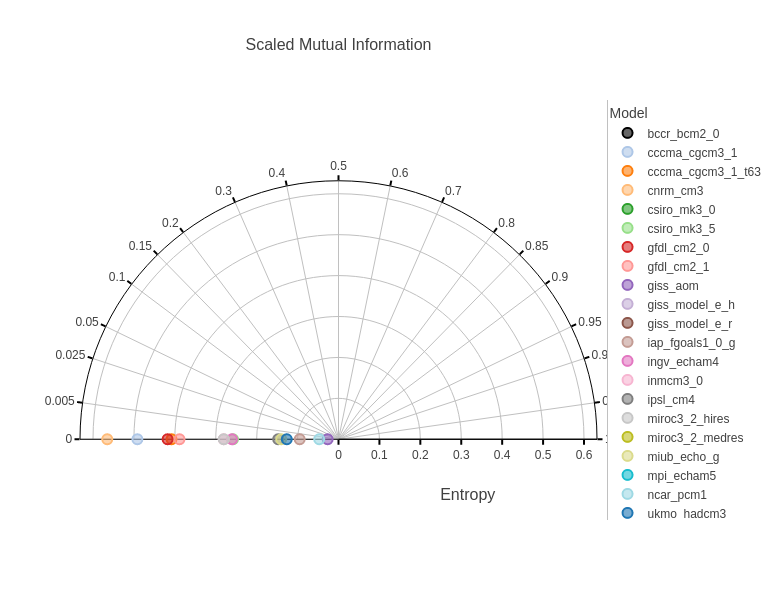

In [25]:
chart_mi_res = diag.chart_create_mi_diagram(df_dataset_1_pivoted, 'bccr_bcm2_0', string_mid_type, dict_mi_parameters_features_continous_target_continous)
chart_mi_res.show()

In [26]:
df_dataset_1_mid = diag.df_calculate_mid_properties(df_dataset_1_pivoted, 'bccr_bcm2_0', dict_mi_parameters_features_continous_target_continous)
df_dataset_1_mid

Model   Entropy  Mutual Information  Fixed_MI  Scaled_entropy  \
0         bccr_bcm2_0 -0.731772            3.344044 -0.731772        1.000000   
1       cccma_cgcm3_1  0.491545            0.200957 -0.043975       -0.671718   
2   cccma_cgcm3_1_t63  0.408123            0.143259 -0.031349       -0.557719   
3            cnrm_cm3  0.565183            0.178099 -0.038973       -0.772348   
4         csiro_mk3_0 -0.196525            0.132368 -0.028966        0.268560   
5         csiro_mk3_5  0.257756            0.131548 -0.028786       -0.352235   
6          gfdl_cm2_0  0.417713            0.088154 -0.019291       -0.570823   
7          gfdl_cm2_1  0.388671            0.000000 -0.000000       -0.531137   
8            giss_aom  0.026597            0.194888 -0.042647       -0.036346   
9      giss_model_e_h -0.323224            0.142521 -0.031188        0.441701   
10     giss_model_e_r -0.331292            0.000000 -0.000000        0.452726   
11    iap_fgoals1_0_g  0.094869            0.000000 -0.000000       -0.129643   
12        ingv_echam4  0.260275            0.318694 -0.069739       -0.355677   
13           inmcm3_0  0.280451            0.160111 -0.035037       -0.383249   
14           ipsl_cm4  0.147403            0.131681 -0.028816       -0.201433   
15     miroc3_2_hires  0.280536            0.258658 -0.056602       -0.383366   
16    miroc3_2_medres -0.352516            0.183244 -0.040099        0.481730   
17        miub_echo_g  0.139946            0.029003 -0.006347       -0.191242   
18         mpi_echam5 -0.160114            0.103570 -0.022664        0.218803   
19          ncar_pcm1  0.047149            0.118523 -0.025936       -0.064431   
20        ukmo_hadcm3  0.126401            0.114667 -0.025092       -0.172733   
21       ukmo_hadgem1 -0.372435            0.163712 -0.035825        0.508949   

    Normalized MI   Angle_NMI  Joint_entropies  Scaled MI   Angle_SMI  \
0       -1.000000  180.000000        -0.731772   1.000000    0.000001   
1       -0.043975   92.520403        -0.196252  -0.023993  180.000000   
2       -0.031349   91.796469        -0.292300  -0.030682  180.000000   
3       -0.038973   92.233567        -0.127616  -0.012026  180.000000   
4       -0.076382   94.380620        -0.899331   0.181139  129.622110   
5       -0.028786   91.649568        -0.445230  -0.067950  180.000000   
6       -0.019291   91.105334        -0.294769  -0.018603  180.000000   
7       -0.000000   90.000000        -0.343100  -0.000000  180.000000   
8       -0.042647   92.444240        -0.662528  -1.451739  180.000000   
9       -0.064127   93.676744        -1.023809   0.134996  136.887035   
10      -0.000000   90.000000        -1.063064   0.000000  180.000000   
11      -0.000000   90.000000        -0.636903  -0.000000  180.000000   
12      -0.069739   93.999019        -0.401758  -0.147108  180.000000   
13      -0.035037   92.007878        -0.416284  -0.071069  180.000000   
14      -0.028816   91.651242        -0.555554  -0.148413  180.000000   
15      -0.056602   93.244770        -0.394634  -0.108808  180.000000   
16      -0.078951   94.528268        -1.044189   0.162315  132.482869   
17      -0.006347   90.363636        -0.585480  -0.036284  180.000000   
18      -0.066212   93.796451        -0.869221   0.168138  131.584518   
19      -0.025936   91.486201        -0.658687  -0.495152  180.000000   
20      -0.025092   91.437835        -0.580278  -0.157416  180.000000   
21      -0.068623   93.934912        -1.068382   0.140438  135.982209   

    Root Entropy  
0      -1.000000  
1       0.701102  
2       0.638845  
3       0.751786  
4      -1.000000  
5       0.507697  
6       0.646307  
7       0.623435  
8       0.163085  
9      -1.000000  
10     -1.000000  
11      0.308009  
12      0.510171  
13      0.529576  
14      0.383931  
15      0.529657  
16     -1.000000  
17      0.374093  
18     -1.000000  
19      0.217138  
20      0.355530  
21     -1.000000

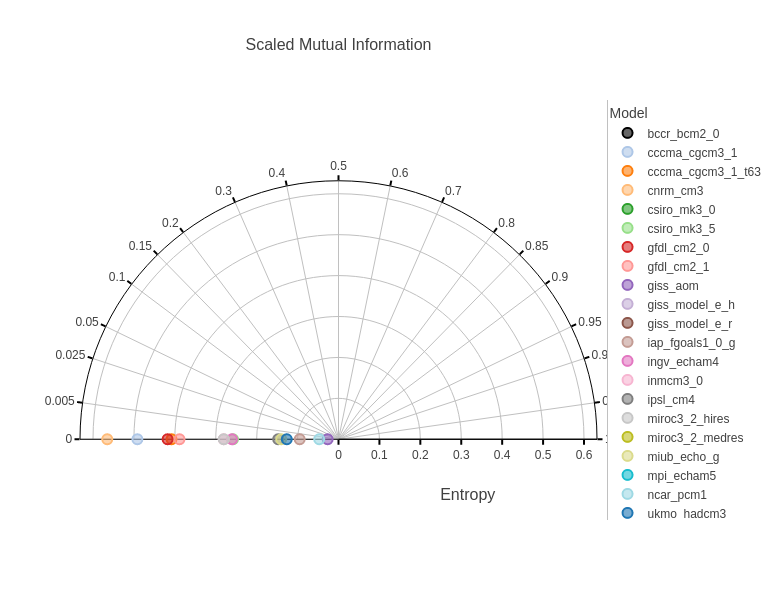

In [27]:
chart_mi_res = diag.chart_create_mi_diagram(df_dataset_1_pivoted, 'bccr_bcm2_0', string_mid_type, dict_mi_parameters_features_continous_target_continous)
chart_mi_res.show()

In [28]:
df_dataset_1_td = diag.df_calculate_td_properties (df_dataset_1_pivoted, 'bccr_bcm2_0')
df_dataset_1_td

Model  Standard Deviation  Correlation      Angle       RMS  \
0         bccr_bcm2_0            0.150708     1.000000   0.000001  0.000000   
1       cccma_cgcm3_1            0.421117     0.447744  63.400940  0.651690   
2   cccma_cgcm3_1_t63            0.426046     0.408067  65.916517  1.429422   
3            cnrm_cm3            0.381168     0.231036  76.641935  1.518590   
4         csiro_mk3_0            0.217599     0.456389  62.845662  0.246113   
5         csiro_mk3_5            0.329518     0.434916  64.220078  2.148455   
6          gfdl_cm2_0            0.339364     0.246686  75.718534  0.336084   
7          gfdl_cm2_1            0.328633     0.250612  75.486247  0.952518   
8            giss_aom            0.298304     0.407816  65.932268  1.915679   
9      giss_model_e_h            0.191953     0.327887  70.859409  2.085016   
10     giss_model_e_r            0.204082     0.202556  78.313556  0.550592   
11    iap_fgoals1_0_g            0.275984     0.265176  74.622571  1.932807   
12        ingv_echam4            0.314295     0.319038  71.395244  2.728204   
13           inmcm3_0            0.313439     0.222387  77.150709  0.722857   
14           ipsl_cm4            0.292139     0.441155  63.822414  0.544193   
15     miroc3_2_hires            0.323302     0.386121  67.286663  1.618969   
16    miroc3_2_medres            0.196674     0.343557  69.906277  0.795419   
17        miub_echo_g            0.266280     0.173241  80.023671  1.154360   
18         mpi_echam5            0.232828     0.219527  77.318748  1.763224   
19          ncar_pcm1            0.282840     0.362574  68.741665  0.325430   
20        ukmo_hadcm3            0.275619     0.395348  66.712330  0.379092   
21       ukmo_hadgem1            0.234121     0.442108  63.761538  0.409120   

    Normalized_RMS  Normalized_STD  
0         0.000000        1.000000  
1         4.324178        2.794250  
2         9.484678        2.826955  
3        10.076338        2.529172  
4         1.633043        1.443843  
5        14.255701        2.186457  
6         2.230024        2.251791  
7         6.320265        2.180585  
8        12.711158        1.979344  
9        13.834764        1.273673  
10        3.653359        1.354153  
11       12.824803        1.831243  
12       18.102523        2.085449  
13        4.796390        2.079770  
14        3.610896        1.938438  
15       10.742389        2.145213  
16        5.277865        1.304996  
17        7.659557        1.766852  
18       11.699565        1.544889  
19        2.159332        1.876735  
20        2.515402        1.828819  
21        2.714645        1.553473

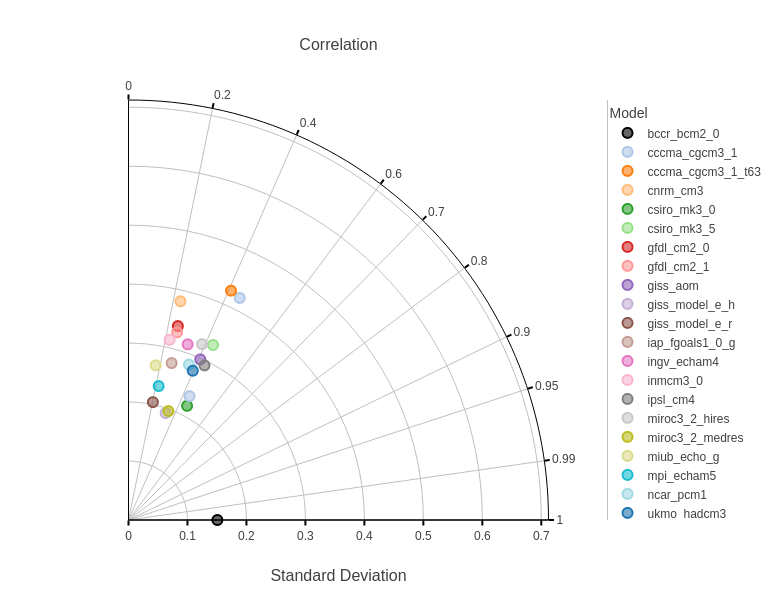

In [29]:
chart_td_res = diag.chart_create_taylor_diagram(df_dataset_1_pivoted, 'bccr_bcm2_0', string_corr_method)
chart_td_res.show()

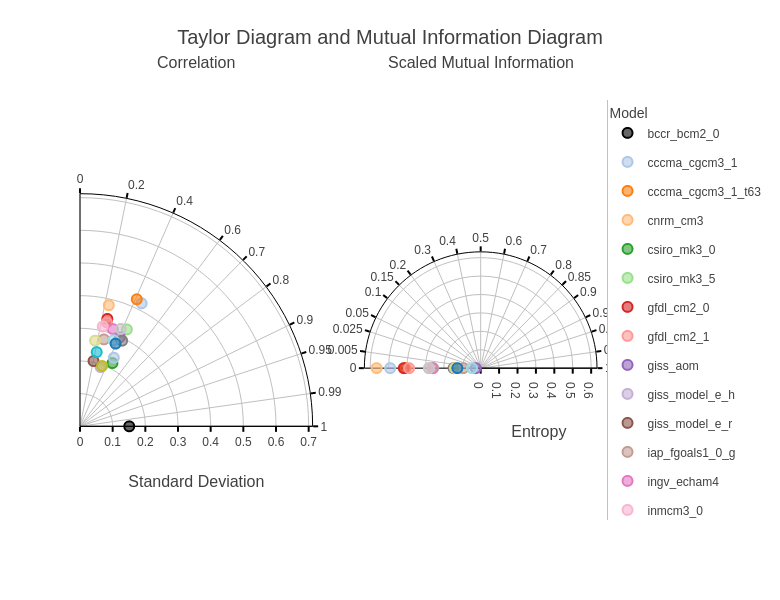

In [30]:
diag.chart_create_all_diagrams(df_dataset_1_pivoted, string_reference_model='bccr_bcm2_0', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)

---
**Interesting use case**: One could exploit the functionality of the library that allows users to visualize two time points at the same time for this example as well. This functionality could be used to evaluate the performance of climate models between two runs. One dataset could come from the first run and the second one from the second run.

---

# 2. Additional datasets (not present in the original paper)
## 2.1. Datasets with discrete reference features

In [31]:
df_iris = datasets.load_iris(as_frame=True, return_X_y=True)
df_iris = pd.concat([df_iris[0], df_iris[1]], axis=1)
df_iris

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  
1         0  
2         0  
3         0  
4         0  
..      ...  
145       2  
146       2  
147       2  
148       2  
149       2  

[150 rows x 5 columns]

In [32]:
# The original Breast Cancer Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29

##  Attribute                     Domain
#   -- -----------------------------------------
#   1. Sample code number            id number
#   2. Clump Thickness               1 - 10
#   3. Uniformity of Cell Size       1 - 10
#   4. Uniformity of Cell Shape      1 - 10
#   5. Marginal Adhesion             1 - 10
#   6. Single Epithelial Cell Size   1 - 10
#   7. Bare Nuclei                   1 - 10
#   8. Bland Chromatin               1 - 10
#   9. Normal Nucleoli               1 - 10
#  10. Mitoses                       1 - 10
#  11. Class:                        (2 for benign, 4 for malignant)

path_breast_cancer = os.path.join(path_root_data, 'Dataset_2',
                                  'Breast_Cancer_Wisconsin_Original',
                                  'breast-cancer-wisconsin.data')

df_breast_cancer = pd.read_csv(path_breast_cancer, header=None, na_values=['?'])
df_breast_cancer.dropna(inplace=True)
df_breast_cancer.drop([0], axis=1, inplace=True)
np_breast_cancer_ground_truth = df_breast_cancer[10].to_numpy()
df_breast_cancer

1   2   3   4   5     6   7   8   9   10
0     5   1   1   1   2   1.0   3   1   1   2
1     5   4   4   5   7  10.0   3   2   1   2
2     3   1   1   1   2   2.0   3   1   1   2
3     6   8   8   1   3   4.0   3   7   1   2
4     4   1   1   3   2   1.0   3   1   1   2
..   ..  ..  ..  ..  ..   ...  ..  ..  ..  ..
694   3   1   1   1   3   2.0   1   1   1   2
695   2   1   1   1   2   1.0   1   1   1   2
696   5  10  10   3   7   3.0   8  10   2   4
697   4   8   6   4   3   4.0  10   6   1   4
698   4   8   8   5   4   5.0  10   4   1   4

[683 rows x 10 columns]

In [33]:
# The original E. Coli Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/ecoli

##  Attribute Information:
#   -- -----------------------------------------
#  1.  Sequence Name: Accession number for the SWISS-PROT database
#  2.  mcg: McGeoch's method for signal sequence recognition.
#  3.  gvh: von Heijne's method for signal sequence recognition.
#  4.  lip: von Heijne's Signal Peptidase II consensus sequence score.
#           Binary attribute.
#  5.  chg: Presence of charge on N-terminus of predicted lipoproteins.
#	   Binary attribute.
#  6.  aac: score of discriminant analysis of the amino acid content of
#	   outer membrane and periplasmic proteins.
#  7. alm1: score of the ALOM membrane spanning region prediction program.
#  8. alm2: score of ALOM program after excluding putative cleavable signal
#	   regions from the sequence.

path_ecoli = os.path.join(path_root_data, 'Dataset_2', 'E_Coli', 'ecoli.data')

df_ecoli = pd.read_csv(path_ecoli, header=None, delim_whitespace=True)
df_ecoli.drop([0], axis=1, inplace=True)
df_ecoli[df_ecoli.columns[-1]] = pd.factorize(df_ecoli[df_ecoli.columns[-1]])[0]
df_ecoli

1     2     3    4     5     6     7  8
0    0.49  0.29  0.48  0.5  0.56  0.24  0.35  0
1    0.07  0.40  0.48  0.5  0.54  0.35  0.44  0
2    0.56  0.40  0.48  0.5  0.49  0.37  0.46  0
3    0.59  0.49  0.48  0.5  0.52  0.45  0.36  0
4    0.23  0.32  0.48  0.5  0.55  0.25  0.35  0
..    ...   ...   ...  ...   ...   ...   ... ..
331  0.74  0.56  0.48  0.5  0.47  0.68  0.30  7
332  0.71  0.57  0.48  0.5  0.48  0.35  0.32  7
333  0.61  0.60  0.48  0.5  0.44  0.39  0.38  7
334  0.59  0.61  0.48  0.5  0.42  0.42  0.37  7
335  0.74  0.74  0.48  0.5  0.31  0.53  0.52  7

[336 rows x 8 columns]

In [34]:
# The original Glass Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/glass+identification

#   Attribute Information:
#   -- -----------------------------------------
#   1. Id number: 1 to 214
#   2. RI: refractive index
#   3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as 
#                  are attributes 4-10)
#   4. Mg: Magnesium
#   5. Al: Aluminum
#   6. Si: Silicon
#   7. K: Potassium
#   8. Ca: Calcium
#   9. Ba: Barium
#  10. Fe: Iron
#  11. Type of glass: (class attribute)
#      -- 1 building_windows_float_processed
#      -- 2 building_windows_non_float_processed
#      -- 3 vehicle_windows_float_processed
#      -- 4 vehicle_windows_non_float_processed (none in this database)
#      -- 5 containers
#      -- 6 tableware
#      -- 7 headlamps

path_glass = os.path.join(path_root_data, 'Dataset_2', 'Glass', 'glass.data')

df_glass = pd.read_csv(path_glass, header=None)
df_glass.drop([0], axis=1, inplace=True)
np_glass_ground_truth = df_glass[10].to_numpy()
df_glass

1      2     3     4      5     6     7     8    9   10
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0   1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0   1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0   1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0   1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0   1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...  ..
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0   7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0   7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0   7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0   7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0   7

[214 rows x 10 columns]

In [35]:
# https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
# List of classifiers comes from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html # noqa
# This list was adapted by adding more models

# IDEA: The diagram could be used to visualize the results of GridSearchCV
# IDEA: since this function already fits multiple models and predicts the data

list_classification_models = [
    ('KNN', KNeighborsClassifier()),
    ('SVM_Linear', LinearSVC()),
    ('SVM_Gaussian', SVC(kernel='rbf')),
    ('Gaussian_PC', GaussianProcessClassifier()),
    ('Decision_Tree_C', DecisionTreeClassifier()),
    ('Random_Forest_C', RandomForestClassifier()),
    ('MLPC', MLPClassifier()),
    ('Ada_Boost_C', AdaBoostClassifier()),
    ('Gaussian_NB', GaussianNB()),
    ('Quadratic_DA', QuadraticDiscriminantAnalysis()),
    ('Gradient_BC', GradientBoostingClassifier()),
    ('SGDC', SGDClassifier())]

list_regression_models = [
    ('KNN', KNeighborsRegressor()),
    ('SVM_Linear', LinearSVR()),
    ('SVM_Gaussian', SVR(kernel='rbf')),
    ('Gaussian_PR', GaussianProcessRegressor()),
    ('Decision_Tree_R', DecisionTreeRegressor()),
    ('Random_Forest_R', RandomForestRegressor()),
    ('MLPR', MLPRegressor()),
    ('Ada_Boost_R', AdaBoostRegressor()),
    ('Gradient_BR', GradientBoostingRegressor()),
    ('SGDR', SGDRegressor())]


def tuple_preprocess_dataset(np_x, np_y):
    
    np_x_train, np_x_test, np_y_train, np_y_test = train_test_split(
        np_x, np_y, test_size=0.33, random_state=INT_RANDOM_SEED)
    
    constructor_scaler = StandardScaler()
    np_scaled_x_train = constructor_scaler.fit_transform(np_x_train)
    np_scaled_x_test = constructor_scaler.transform(np_x_test)
    
    return np_scaled_x_train, np_scaled_x_test, np_y_train, np_y_test


def df_fit_all_models(df_input, list_models, bool_is_classification=True):
    np_x = df_input[df_input.columns[:-1]].to_numpy()
    np_y = df_input[df_input.columns[-1]].to_numpy()

    np_x_train, np_x_test, np_y_train, np_y_test = tuple_preprocess_dataset(
        np_x, np_y)    


    list_scoring = ['accuracy', 'precision_weighted', 'recall_weighted',
                    'f1_weighted', 'roc_auc']

    df_result = pd.DataFrame()
    df_result['Ground_Truth'] = np_y_test

    for string_model_name, constructor_one_model in list_models:
        
        if bool_is_classification is True:
            constructor_kfold = StratifiedKFold(n_splits=5, shuffle=True,
                                                random_state=INT_RANDOM_SEED)
            cv_results = cross_validate(
                constructor_one_model, np_x_train, np_y_train,
                cv=constructor_kfold, scoring=list_scoring)

        model_tmp = constructor_one_model.fit(np_x_train, np_y_train)
        np_y_pred = model_tmp.predict(np_x_test)

        df_result[string_model_name] = np_y_pred

    return df_result


def list_evaluate_all_datasets(list_of_datasets, list_models, bool_is_classification=True):
    list_df_results = []
    
    for df_tmp in list_of_datasets:
        list_df_results.append(df_fit_all_models(
            df_tmp, list_models, bool_is_classification))
    
    return list_df_results


In [36]:
list_datasets = [df_iris, df_glass, df_breast_cancer, df_ecoli]
list_results = list_evaluate_all_datasets(
    list_datasets, list_classification_models, bool_is_classification=True)

/home/alexein-personal-one/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/alexein-personal-one/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/alexein-personal-one/miniconda3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 878, in fit
    raise ValueError(
ValueError: y has only 1 sample in class 3, covariance is ill defined.




### 2.1.1. Dataset - Iris

In [37]:
list_results[0].head()

Ground_Truth  KNN  SVM_Linear  SVM_Gaussian  Gaussian_PC  Decision_Tree_C  \
0             1    1           1             1            1                1   
1             0    0           0             0            0                0   
2             2    2           2             2            2                2   
3             1    1           1             1            1                1   
4             1    1           1             1            1                1   

   Random_Forest_C  MLPC  Ada_Boost_C  Gaussian_NB  Quadratic_DA  Gradient_BC  \
0                1     1            1            1             1            1   
1                0     0            0            0             0            0   
2                2     2            2            2             2            2   
3                1     1            1            1             1            1   
4                1     1            1            1             1            1   

   SGDC  
0     1  
1     0  
2     2  
3     1  
4     1

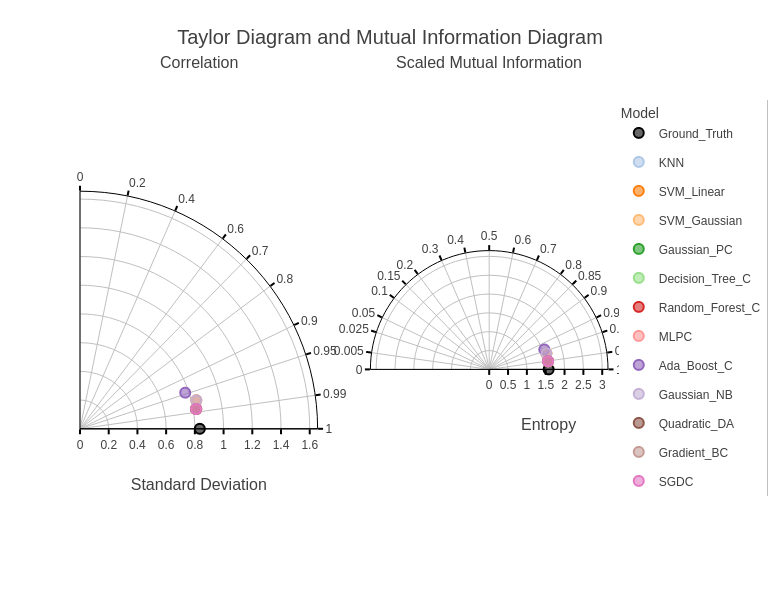

In [38]:
diag.chart_create_all_diagrams(list_results[0], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

### 2.1.2. Dataset - Glass

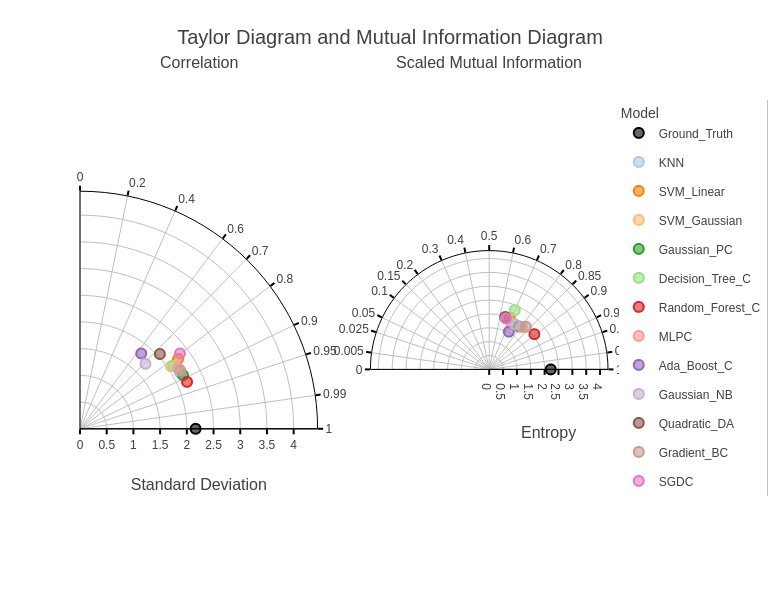

In [39]:
diag.chart_create_all_diagrams(list_results[1], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

### 2.1.3. Dataset - Breast Cancer

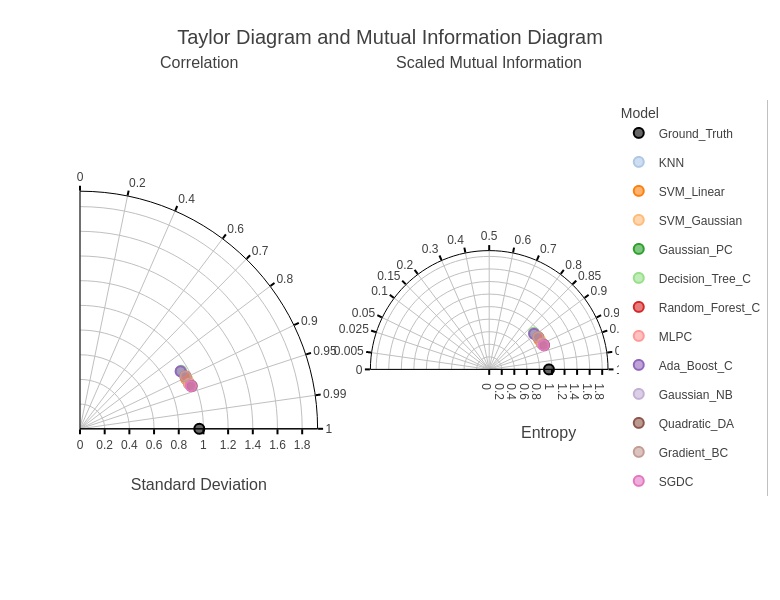

In [40]:
diag.chart_create_all_diagrams(list_results[2], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

### 2.1.4. Dataset - E. Coli

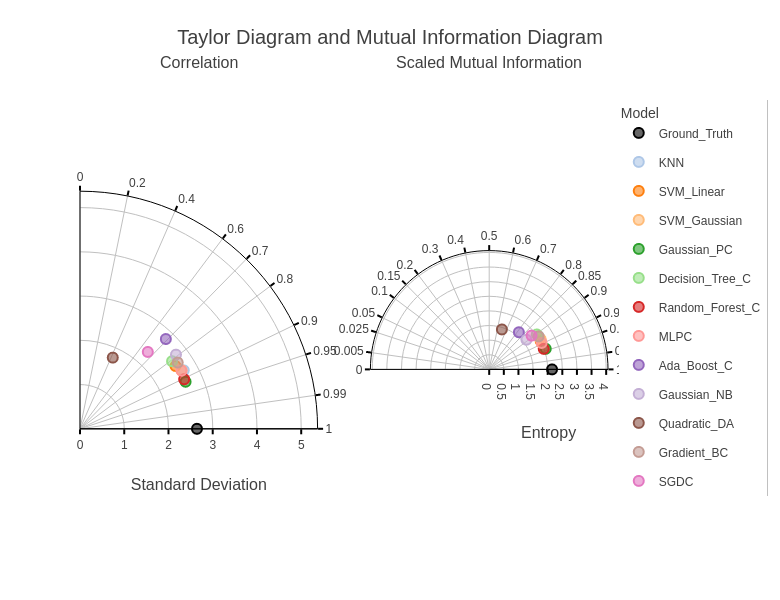

In [41]:
diag.chart_create_all_diagrams(list_results[3], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

## 2.2. Datasets with continous reference features

In [42]:
df_california = datasets.fetch_california_housing(as_frame=True, return_X_y=True)
df_california = pd.concat([df_california[0], df_california[1]], axis=1)
df_california.dropna(inplace=True)
df_california

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  MedHouseVal  
0        -122.23        4.526  
1        -122.22        3.585  
2        -122.24        3.521  
3        -122.25        3.413  
4        -122.25        3.422  
...          ...          ...  
20635    -121.09        0.781  
20636    -121.21        0.771  
20637    -121.22        0.923  
20638    -121.32        0.847  
20639    -121.24        0.894  

[20640 rows x 9 columns]

In [43]:
df_ames = datasets.fetch_openml(name="house_prices", as_frame=True, return_X_y=True)
df_ames = pd.concat([df_ames[0], df_ames[1]], axis=1)
df_ames.dropna(inplace=True, axis=1)  # We delete columns, not rows as above
list_categorical_columns = df_ames.dtypes.pipe(lambda x: x[x == 'object']).index

for string_one_columd in list_categorical_columns:
    df_ames[string_one_columd] = pd.factorize(df_ames[string_one_columd])[0]

df_ames

Id  MSSubClass  MSZoning  LotArea  Street  LotShape  LandContour  \
0        1.0        60.0         0   8450.0       0         0            0   
1        2.0        20.0         0   9600.0       0         0            0   
2        3.0        60.0         0  11250.0       0         1            0   
3        4.0        70.0         0   9550.0       0         1            0   
4        5.0        60.0         0  14260.0       0         1            0   
...      ...         ...       ...      ...     ...       ...          ...   
1455  1456.0        60.0         0   7917.0       0         0            0   
1456  1457.0        20.0         0  13175.0       0         0            0   
1457  1458.0        70.0         0   9042.0       0         0            0   
1458  1459.0        20.0         0   9717.0       0         0            0   
1459  1460.0        20.0         0   9937.0       0         0            0   

      Utilities  LotConfig  LandSlope  ...  EnclosedPorch  3SsnPorch  \
0             0          0          0  ...            0.0        0.0   
1             0          1          0  ...            0.0        0.0   
2             0          0          0  ...            0.0        0.0   
3             0          2          0  ...          272.0        0.0   
4             0          1          0  ...            0.0        0.0   
...         ...        ...        ...  ...            ...        ...   
1455          0          0          0  ...            0.0        0.0   
1456          0          0          0  ...            0.0        0.0   
1457          0          0          0  ...            0.0        0.0   
1458          0          0          0  ...          112.0        0.0   
1459          0          0          0  ...            0.0        0.0   

      ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SaleType  SaleCondition  \
0             0.0       0.0      0.0     2.0  2008.0         0              0   
1             0.0       0.0      0.0     5.0  2007.0         0              0   
2             0.0       0.0      0.0     9.0  2008.0         0              0   
3             0.0       0.0      0.0     2.0  2006.0         0              1   
4             0.0       0.0      0.0    12.0  2008.0         0              0   
...           ...       ...      ...     ...     ...       ...            ...   
1455          0.0       0.0      0.0     8.0  2007.0         0              0   
1456          0.0       0.0      0.0     2.0  2010.0         0              0   
1457          0.0       0.0   2500.0     5.0  2010.0         0              0   
1458          0.0       0.0      0.0     4.0  2010.0         0              0   
1459          0.0       0.0      0.0     6.0  2008.0         0              0   

      SalePrice  
0      208500.0  
1      181500.0  
2      223500.0  
3      140000.0  
4      250000.0  
...         ...  
1455   175000.0  
1456   210000.0  
1457   266500.0  
1458   142125.0  
1459   147500.0  

[1460 rows x 62 columns]

In [44]:
list_datasets = [df_california, df_ames]
list_results = list_evaluate_all_datasets(
    list_datasets, list_regression_models, bool_is_classification=False)

### 2.2.1. Dataset - California Housing

In [45]:
list_results[0].head()

Ground_Truth       KNN  SVM_Linear  SVM_Gaussian  Gaussian_PR  \
0       0.47700  0.525400    0.593510      0.510497    -2.443687   
1       0.45800  0.730200    1.599203      1.583848    -2.859123   
2       5.00001  4.750006    2.582268      3.574950     8.158992   
3       2.18600  2.807800    2.709019      2.495711    -0.020985   
4       2.78000  2.726200    2.371549      2.545908     1.859102   

   Decision_Tree_R  Random_Forest_R      MLPR  Ada_Boost_R  Gradient_BR  \
0          0.56500         0.517660  0.520248     1.690779     0.540505   
1          0.52100         0.767920  1.245444     2.097073     1.047469   
2          5.00001         4.792916  4.445288     3.301009     4.010948   
3          2.84200         2.612180  2.589515     3.114075     2.494539   
4          2.02500         2.293030  2.861297     2.794198     2.224271   

       SGDR  
0  0.755928  
1  1.773070  
2  2.792428  
3  2.796778  
4  2.641187

In [46]:
df_california_properties = diag.df_calculate_all_properties(list_results[0], string_reference_model='Ground_Truth', string_corr_method='pearson', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)
df_california_properties

/home/alexein-personal-one/miniconda3/lib/python3.10/site-packages/scipy/stats/_entropy.py:293: RuntimeWarning:

divide by zero encountered in log

/home/alexein-personal-one/miniconda3/lib/python3.10/site-packages/scipy/stats/_entropy.py:293: RuntimeWarning:

divide by zero encountered in log

/home/alexein-personal-one/miniconda3/lib/python3.10/site-packages/scipy/stats/_entropy.py:293: RuntimeWarning:

divide by zero encountered in log

/home/alexein-personal-one/Downloads/Model-Comparison-Polar-Diagrams/Source/diagrams.py:390: RuntimeWarning:

invalid value encountered in double_scalars

/home/alexein-personal-one/Downloads/Model-Comparison-Polar-Diagrams/Source/diagrams.py:405: RuntimeWarning:

invalid value encountered in double_scalars

/home/alexein-personal-one/Downloads/Model-Comparison-Polar-Diagrams/Source/diagrams.py:431: RuntimeWarning:

invalid value encountered in double_scalars



Model  Standard Deviation  Correlation      Angle        RMS  \
0      Ground_Truth            1.154379     1.000000   0.000000   0.000000   
1               KNN            0.971466     0.818874  35.027780   0.663473   
2        SVM_Linear            0.911976     0.766536  39.956123   0.754606   
3      SVM_Gaussian            0.963134     0.859581  30.730429   0.597714   
4       Gaussian_PR           48.723986     0.018094  88.963230  48.724735   
5   Decision_Tree_R            1.161645     0.798732  36.990799   0.735045   
6   Random_Forest_R            1.009187     0.897527  26.165080   0.509891   
7              MLPR            1.003038     0.876960  28.722219   0.555179   
8       Ada_Boost_R            0.609298     0.812429  35.666084   0.879891   
9       Gradient_BR            0.992407     0.883812  27.894311   0.540785   
10             SGDR            0.888624     0.776213  39.084823   0.727840   

    Normalized_RMS  Normalized_STD   Entropy  Mutual Information  Fixed_MI  \
0         0.000000        1.000000      -inf            6.927544      -inf   
1         0.574744        0.841548  1.809432            0.699599      -inf   
2         0.653690        0.790015  1.824535            0.589230      -inf   
3         0.517780        0.834331  1.852000            0.787200      -inf   
4        42.208597       42.207948  5.447739            0.092044      -inf   
5         0.636745        1.006294      -inf            0.620150      -inf   
6         0.441701        0.874225  1.853434            0.968928      -inf   
7         0.480933        0.868898  1.966082            0.846447      -inf   
8         0.762220        0.527814      -inf            0.640568      -inf   
9         0.468464        0.859688  1.879392            0.843282      -inf   
10        0.630504        0.769785  1.800975            0.587925      -inf   

    Scaled_entropy  Normalized MI  Angle_NMI  Joint_entropies  Scaled MI  \
0              NaN            NaN        NaN              NaN        NaN   
1             -0.0           -inf      180.0              NaN        NaN   
2             -0.0           -inf      180.0              NaN        NaN   
3             -0.0           -inf      180.0              NaN        NaN   
4             -0.0           -inf      180.0              NaN        NaN   
5              NaN            NaN        NaN              NaN        NaN   
6             -0.0           -inf      180.0              NaN        NaN   
7             -0.0           -inf      180.0              NaN        NaN   
8              NaN            NaN        NaN              NaN        NaN   
9             -0.0           -inf      180.0              NaN        NaN   
10            -0.0           -inf      180.0              NaN        NaN   

    Angle_SMI  Root Entropy  
0         NaN     -1.000000  
1         NaN      1.345151  
2         NaN      1.350754  
3         NaN      1.360882  
4         NaN      2.334039  
5         NaN     -1.000000  
6         NaN      1.361409  
7         NaN      1.402171  
8         NaN     -1.000000  
9         NaN      1.370909  
10        NaN      1.342004

/home/alexein-personal-one/miniconda3/lib/python3.10/site-packages/scipy/stats/_entropy.py:293: RuntimeWarning:

divide by zero encountered in log

/home/alexein-personal-one/miniconda3/lib/python3.10/site-packages/scipy/stats/_entropy.py:293: RuntimeWarning:

divide by zero encountered in log

/home/alexein-personal-one/miniconda3/lib/python3.10/site-packages/scipy/stats/_entropy.py:293: RuntimeWarning:

divide by zero encountered in log

/home/alexein-personal-one/Downloads/Model-Comparison-Polar-Diagrams/Source/diagrams.py:390: RuntimeWarning:

invalid value encountered in double_scalars

/home/alexein-personal-one/Downloads/Model-Comparison-Polar-Diagrams/Source/diagrams.py:405: RuntimeWarning:

invalid value encountered in double_scalars

/home/alexein-personal-one/Downloads/Model-Comparison-Polar-Diagrams/Source/diagrams.py:431: RuntimeWarning:

invalid value encountered in double_scalars



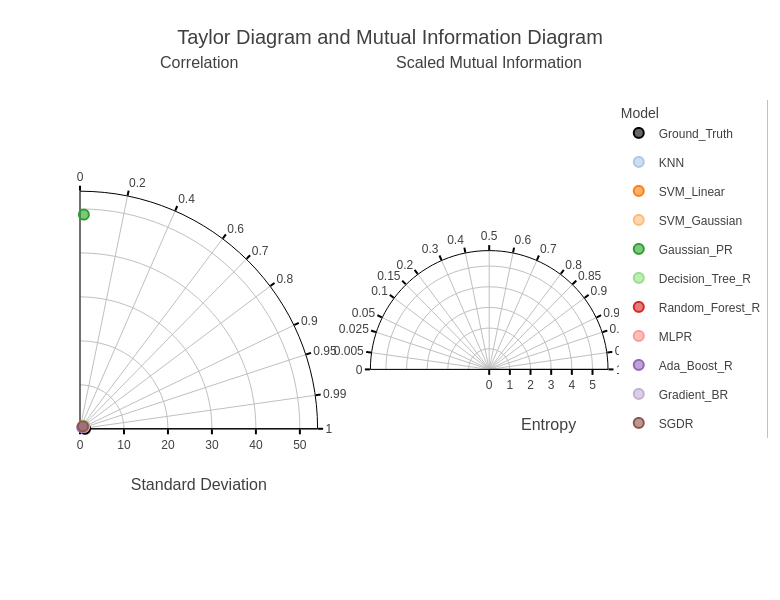

In [47]:
diag.chart_create_all_diagrams(list_results[0], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)

### 2.2.2. Dataset - Ames Housing

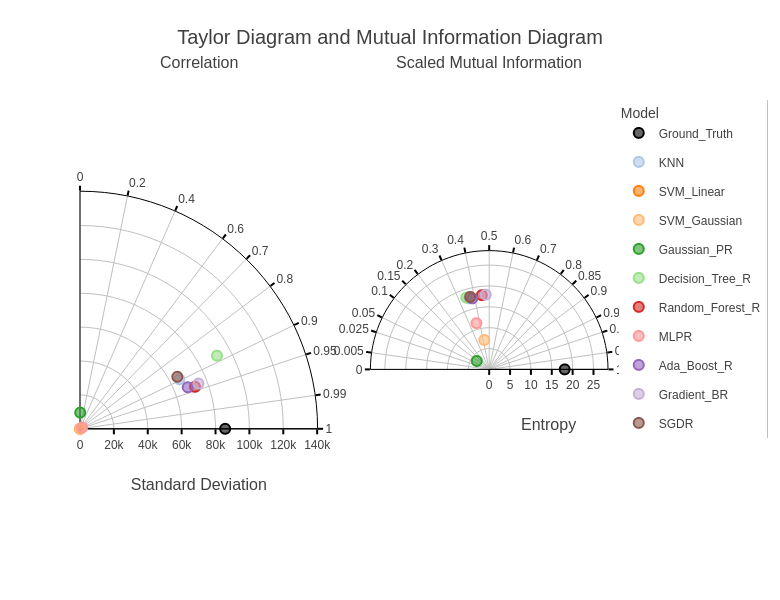

In [48]:
diag.chart_create_all_diagrams(list_results[1], string_reference_model='Ground_Truth', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)

## 2.3. Biological/Medical model/patient comparison

In [49]:
# The original HCV Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/HCV+data

#   Attribute Information:
#   -- -----------------------------------------
#   All attributes except Category and Sex are numerical. The laboratory data are the attributes 5-14.
# 1) X (Patient ID/No.)
# 2) Category (diagnosis) (values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')
# 3) Age (in years)
# 4) Sex (f,m)
# 5) ALB
# 6) ALP
# 7) ALT
# 8) AST
# 9) BIL
# 10) CHE
# 11) CHOL
# 12) CREA
# 13) GGT
# 14) PROT 

path_hcv = os.path.join(path_root_data, 'Dataset_3', 'hcvdat0.csv')

df_hcv = pd.read_csv(path_hcv)
df_hcv.drop(['Unnamed: 0'], axis=1, inplace=True)
df_hcv.dropna(inplace=True)
df_hepatitis_patients = df_hcv[df_hcv['Category'] == '1=Hepatitis']
df_hepatitis_patients = df_hepatitis_patients.drop(
    ['Category', 'Age', 'Sex'], axis=1).reset_index(drop=True)
df_hepatitis_patients['Patient'] = ['Patient_' + str(i) for i in
                                  range(df_hepatitis_patients.shape[0])]
df_hepatitis_patients_pivoted = df_hepatitis_patients.pivot_table(
    columns='Patient')
df_hepatitis_patients_pivoted = df_hepatitis_patients_pivoted[
    ['Patient_' + str(i) for i in range(df_hepatitis_patients.shape[0])]]
df_hepatitis_patients_pivoted

Patient  Patient_0  Patient_1  Patient_2  Patient_3  Patient_4  Patient_5  \
ALB          47.00      42.00      45.00      45.00      41.00      46.00   
ALP          19.10      38.20      27.50      34.60      34.40      36.70   
ALT          38.90      63.30      10.50      44.30      12.10       7.40   
AST         164.20     187.70      37.80      96.20      60.90      31.60   
BIL          17.00      14.00      10.00      16.00       6.00       9.00   
CHE           7.09       6.00       8.77      10.11      13.80       9.71   
CHOL          3.20       4.28       3.20       6.28       5.48       5.37   
CREA         79.30      66.90      55.20      81.20      45.40      82.30   
GGT          90.40      40.20      35.90      48.10      33.10      34.40   
PROT         70.10      70.50      74.50      82.10      71.10      71.60   

Patient  Patient_6  Patient_7  Patient_8  Patient_9  Patient_10  Patient_11  \
ALB          47.00      44.00      41.00      42.00       49.00       48.00   
ALP          37.90      32.90      20.60      39.60       27.30       59.50   
ALT          13.30       9.40      15.20      26.50       40.20       11.60   
AST          48.40      32.00      53.50      77.60       31.10       39.00   
BIL           8.00      14.00      24.00      42.00       13.00        7.00   
CHE          10.30      11.42      10.23       9.67        8.91       16.41   
CHOL          4.14       5.73       4.89       9.67        4.07        4.65   
CREA         69.20      68.60      81.80      57.70       81.50       66.40   
GGT          68.20      40.60      57.90     143.40       27.60      158.20   
PROT         76.00      70.90      71.10      75.80       72.80       72.70   

Patient  Patient_12  Patient_13  Patient_14  Patient_15  Patient_16  \
ALB           42.00       43.00       37.00       43.00       43.00   
ALP           41.60       37.20      114.00       99.10       29.60   
ALT           10.20       21.40       27.80       12.20        3.80   
AST           38.10      132.80      324.00       63.20       16.70   
BIL           17.00        5.00       67.00       13.00        6.00   
CHE            9.54       10.12        5.75        5.95        6.88   
CHOL           7.04        5.23        3.09        6.15        5.72   
CREA          75.30       76.20       97.70      147.30       58.80   
GGT           92.10       76.40      392.20      491.00       11.50   
PROT          72.30       76.70       77.30       65.60       78.20   

Patient  Patient_17  Patient_18  Patient_19  
ALB           37.00       40.00       50.00  
ALP           31.20       32.70       34.40  
ALT            8.20        9.00       27.40  
AST           38.30       46.00      114.40  
BIL            7.00       10.00       22.00  
CHE            7.08        7.51        9.48  
CHOL           5.30        4.67        4.62  
CREA          60.80       56.60       61.90  
GGT           24.70       22.30      169.80  
PROT          82.40       70.10       86.00

### 2.3.1. Dataset - Hepatitis

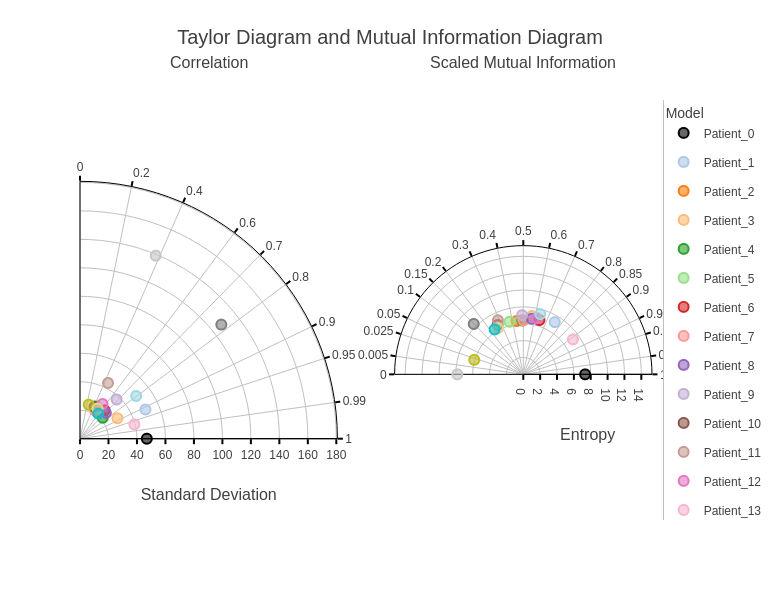

In [50]:
diag.chart_create_all_diagrams(df_hepatitis_patients_pivoted, string_reference_model='Patient_0', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_continous_target_continous)

In [51]:
# The original Fertility Dataset can be found on the link below
# https://archive.ics.uci.edu/ml/datasets/Fertility

#   Attribute Information:
#   -- -----------------------------------------
# Season in which the analysis was performed. 1) winter, 2) spring, 3) Summer, 4) fall. (-1, -0.33, 0.33, 1)
# Age at the time of analysis. 18-36 (0, 1)
# Childish diseases (ie , chicken pox, measles, mumps, polio) 1) yes, 2) no. (0, 1)
# Accident or serious trauma 1) yes, 2) no. (0, 1)
# Surgical intervention 1) yes, 2) no. (0, 1)
# High fevers in the last year 1) less than three months ago, 2) more than three months ago, 3) no. (-1, 0, 1)
# Frequency of alcohol consumption 1) several times a day, 2) every day, 3) several times a week, 4) once a week, 5) hardly ever or never (0, 1)
# Smoking habit 1) never, 2) occasional 3) daily. (-1, 0, 1)
# Number of hours spent sitting per day ene-16 (0, 1)
# Output: Diagnosis normal (N), altered (O) 

path_fertility = os.path.join(path_root_data, 'Dataset_3', 'fertility_Diagnosis.txt')

df_fertility = pd.read_csv(path_fertility, header=None)
df_fertility.dropna(inplace=True)
df_fertility_patients = df_fertility[df_fertility[9] == 'O']
df_fertility_patients = df_fertility_patients.drop([9], axis=1).reset_index(
    drop=True)
df_fertility_patients['Patient'] = ['Patient_' + str(i) for i in
                                  range(df_fertility_patients.shape[0])]
df_fertility_patients_pivoted = df_fertility_patients.pivot_table(
    columns='Patient')
df_fertility_patients_pivoted = df_fertility_patients_pivoted[
    ['Patient_' + str(i) for i in range(df_fertility_patients.shape[0])]]

for string_column in df_fertility_patients_pivoted.columns:
    df_fertility_patients_pivoted[string_column] = pd.factorize(df_fertility_patients_pivoted[string_column])[0]

df_fertility_patients_pivoted

Patient  Patient_0  Patient_1  Patient_2  Patient_3  Patient_4  Patient_5  \
0                0          0          0          0          0          0   
1                1          1          1          1          1          1   
2                2          2          0          0          0          0   
3                3          2          2          2          2          2   
4                2          3          0          2          0          0   
5                3          3          2          2          3          2   
6                4          4          3          3          0          3   
7                2          5          4          0          3          4   
8                5          6          5          4          4          5   

Patient  Patient_6  Patient_7  Patient_8  Patient_9  Patient_10  Patient_11  
0                0          0          0          0           0           0  
1                1          1          1          1           1           1  
2                0          2          2          2           2           2  
3                0          2          2          2           3           3  
4                2          0          3          3           3           2  
5                0          2          2          4           2           3  
6                3          3          4          5           2           4  
7                4          2          2          3           2           5  
8                5          4          5          6           4           6

### 2.3.2. Dataset - Fertility

In [52]:
diag.df_calculate_all_properties(df_fertility_patients_pivoted, string_reference_model='Patient_0', string_corr_method='pearson', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)

Model  Standard Deviation  Correlation      Angle       RMS  \
0    Patient_0            1.422916     1.000000   0.000000  0.000000   
1    Patient_1            1.791613     0.803895  36.496297  1.154701   
2    Patient_2            1.728483     0.742903  42.020703  1.290994   
3    Patient_3            1.342561     0.859515  30.737867  1.154701   
4    Patient_4            1.498971     0.532513  57.824595  1.732051   
5    Patient_5            1.728483     0.742903  42.020703  1.290994   
6    Patient_6            1.825742     0.570266  55.231227  1.732051   
7    Patient_7            1.227262     0.883707  27.907208  0.942809   
8    Patient_8            1.414214     0.920263  23.035480  0.577350   
9    Patient_9            1.791613     0.934649  20.828430  0.816497   
10  Patient_10            1.099944     0.820348  34.880307  0.881917   
11  Patient_11            1.791613     0.847480  32.061372  1.054093   

    Normalized_RMS  Normalized_STD   Entropy  Mutual Information  Fixed_MI  \
0         0.000000        1.000000  2.419382            1.676988  2.419382   
1         0.811503        1.259113  2.725481            1.368922  1.974938   
2         0.907288        1.214747  2.419382            1.464816  2.113283   
3         0.811503        0.943527  2.113283            1.252645  1.807185   
4         1.217254        1.053450  2.058814            1.060857  1.530493   
5         0.907288        1.214747  2.419382            1.464816  2.113283   
6         1.217254        1.283098  2.281036            1.214890  1.752715   
7         0.662589        0.862498  2.058814            1.214890  1.752715   
8         0.405751        0.993884  2.281036            1.368922  1.974938   
9         0.573819        1.259113  2.725481            1.522955  2.197160   
10        0.619795        0.773021  2.058814            1.060857  1.530493   
11        0.740797        1.259113  2.725481            1.676988  2.419382   

    Scaled_entropy  Normalized MI  Angle_NMI  Joint_entropies  Scaled MI  \
0         1.000000       1.000000   0.000000         2.419382   1.000000   
1         1.126519       0.769094  39.727372         3.169925   0.949412   
2         1.000000       0.873481  29.134331         2.725481   0.983993   
3         0.873481       0.799229  36.943419         2.725481   0.963349   
4         0.850967       0.685758  46.704786         2.947703   0.905719   
5         1.000000       0.873481  29.134331         2.725481   0.983993   
6         0.942818       0.746093  41.746918         2.947703   0.936178   
7         0.850967       0.785327  38.249055         2.725481   0.959032   
8         0.942818       0.840688  32.787115         2.725481   0.975349   
9         1.126519       0.855634  31.170189         2.947703   0.982195   
10        0.850967       0.685758  46.704786         2.947703   0.905719   
11        1.126519       0.942173  19.580248         2.725481   1.000000   

    Angle_SMI  Root Entropy  
0    0.000000      1.555436  
1   25.996026      1.650903  
2   14.537009      1.555436  
3   22.074314      1.453714  
4   35.763312      1.434857  
5   14.537009      1.555436  
6   29.266395      1.510310  
7   23.355431      1.434857  
8   18.066517      1.510310  
9   15.336234      1.650903  
10  35.763312      1.434857  
11   0.000002      1.650903

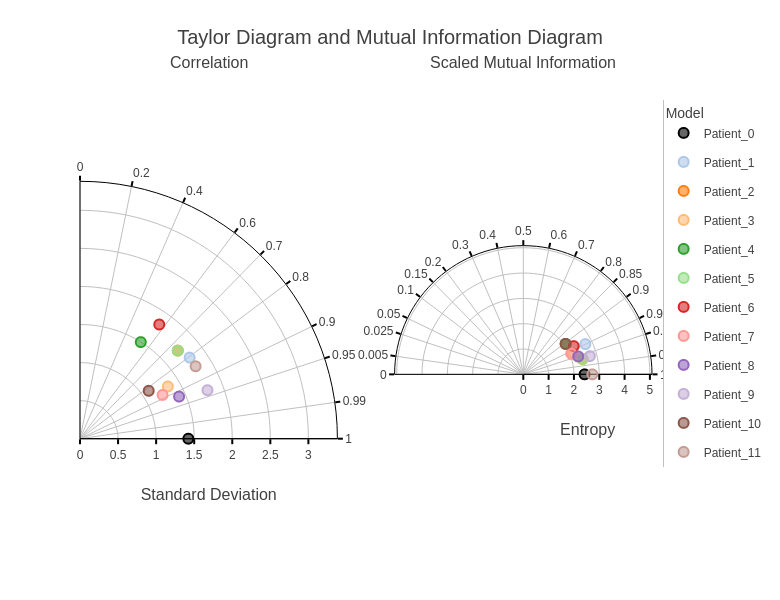

In [53]:
diag.chart_create_all_diagrams(df_fertility_patients_pivoted, string_reference_model='Patient_0', string_corr_method='pearson', string_mid_type='scaled', dict_mi_parameters=dict_mi_parameters_features_discrete_target_discrete)